In [1]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
from get_draws.api import get_draws
import gbd_mapping as gbd

In [2]:
# load birth weight relative risk data
rr = get_draws('rei_id',
                 339,
                 source='rr',
                 location_id=1,
                 year_id=2017,
                 gbd_round_id=5)
# restrict to a single cause because constant across all causes
rr = rr.loc[rr.cause_id==302]
rr.head()

,rei_id,modelable_entity_id,location_id,year_id,age_group_id,sex_id,cause_id,mortality,morbidity,metric_id,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,339,10810,1,2017,2,2,302,1,0,3,...,1253.245727,1771.781708,1517.861885,1346.872060,1471.897235,1966.529558,1765.690073,1232.499038,1558.282834,1687.899443
1,339,10810,1,2017,2,2,302,1,0,3,...,991.158986,983.323610,1278.192810,1158.319967,723.912823,1498.245611,836.500798,783.851805,894.297486,1536.704340
2,339,10810,1,2017,2,2,302,1,0,3,...,993.825854,982.769387,849.074108,1097.570824,902.277603,1024.484585,906.731242,727.757437,1026.692234,968.702386
3,339,10810,1,2017,2,2,302,1,0,3,...,349.864284,392.692300,367.295329,500.956454,431.629085,450.509522,348.765813,355.806447,512.758871,513.870580
4,339,10810,1,2017,2,2,302,1,0,3,...,247.792538,259.532581,299.661652,256.214246,333.453194,247.771436,192.064478,212.459251,302.010750,289.968965


In [3]:
# test to see if rrs vary by sex and/or age group
test = rr.loc[rr.parameter=='cat22']
test

# NOTE: RRs are sex AND age specific

,rei_id,modelable_entity_id,location_id,year_id,age_group_id,sex_id,cause_id,mortality,morbidity,metric_id,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
18,339,10810,1,2017,2,2,302,1,0,3,...,111.508846,134.653176,109.838113,96.813644,154.317260,122.849662,83.743662,114.221907,63.862641,114.333626
873,339,10810,1,2017,3,2,302,1,0,3,...,54.978123,62.313678,59.902892,49.788200,52.423625,58.363774,50.265458,53.207286,53.838266,58.135810
1728,339,10810,1,2017,3,1,302,1,0,3,...,65.491781,53.662514,47.102620,62.132671,47.225407,41.568002,50.684558,47.499756,67.987966,42.693142
2583,339,10810,1,2017,2,1,302,1,0,3,...,83.897587,103.996966,106.067613,125.343963,128.928342,81.572753,120.392865,148.281878,138.038343,162.090265


In [4]:
# reformat data
rrs = rr.set_index(['sex_id','age_group_id','parameter'])
rrs = rrs.drop(columns=[c for c in rrs.columns if 'draw' not in c])
rrs = pd.DataFrame(rrs.stack()).reset_index().rename(columns={'level_3':'draw',0:'value'})
rrs.head()

,sex_id,age_group_id,parameter,draw,value
0,2,2,cat2,draw_0,1687.899443
1,2,2,cat2,draw_1,1597.199010
2,2,2,cat2,draw_10,2034.558316
3,2,2,cat2,draw_100,1630.650911
4,2,2,cat2,draw_101,1261.999826


In [5]:
mean_rrs = rrs.groupby(['sex_id','age_group_id','parameter']).mean()
mean_rrs.head()

value
sex_id age_group_id parameter            
1      2            cat10      955.582875
                    cat106     166.686129
                    cat11      497.816724
                    cat116     174.066286
                    cat117      67.301640

In [7]:
categories = gbd.risk_factors.low_birth_weight_and_short_gestation.categories

In [8]:

# make dataframe that maps from each category to gestatation_age_start,
# gestatation_age_end, birth_weight_start, and birth weight end

s = pd.Series(categories.to_dict())

In [9]:
# set random seed for reproducibility
np.random.seed(12345)

In [10]:
def ga_bw_list(cat):
    numbers_only = cat.replace('Birth prevalence - [', '') \
                    .replace(',', '')\
                    .replace(') wks [', ' ')\
                    .replace(') g', '')
    numbers_only = numbers_only.split()
    numbers_only = [int(numbers_only[i]) for i in range(4)]
    
    return numbers_only


i = np.random.randint(len(s))
s.iloc[i], ga_bw_list(s.iloc[i])

('Birth prevalence - [36, 37) wks, [4000, 4500) g', [36, 37, 4000, 4500])

In [11]:
cat_df = pd.DataFrame(s.map(ga_bw_list).to_dict(), index=['ga_start', 'ga_end', 'bw_start', 'bw_end']).T
cat_df = cat_df.reset_index().rename(columns={'index':'parameter'})
cat_df.head()

,parameter,ga_start,ga_end,bw_start,bw_end
0,cat2,0,24,0,500
1,cat8,0,24,500,1000
2,cat10,24,26,500,1000
3,cat11,26,28,500,1000
4,cat14,30,32,500,1000


In [12]:
data = mean_rrs.reset_index().merge(cat_df, on='parameter')
data.head()

,sex_id,age_group_id,parameter,value,ga_start,ga_end,bw_start,bw_end
0,1,2,cat10,955.582875,24,26,500,1000
1,1,3,cat10,443.357430,24,26,500,1000
2,2,2,cat10,947.143081,24,26,500,1000
3,2,3,cat10,487.548651,24,26,500,1000
4,1,2,cat106,166.686129,36,37,1000,1500


# Overall heat maps

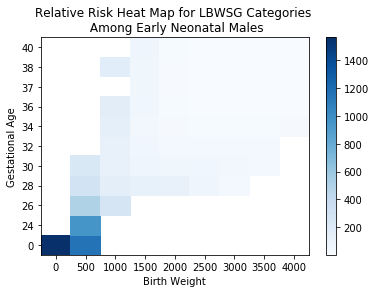

In [22]:
df = data.loc[data.sex_id==1].loc[data.age_group_id==2]
df = pd.DataFrame.pivot_table(df, 
                    index='ga_start', 
                    columns='bw_start', 
                    values='value')

plt.pcolor(df, cmap=plt.cm.Blues)
plt.colorbar()
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.xlabel('Birth Weight')
plt.ylabel('Gestational Age')
plt.title('Relative Risk Heat Map for LBWSG Categories \n Among Early Neonatal Males')
plt.show()

# Truncated heat map

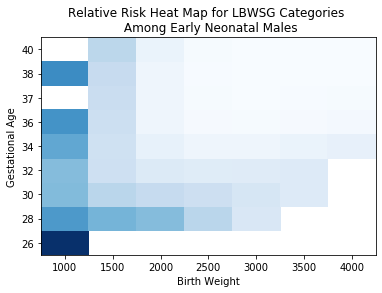

In [17]:
df = data.loc[data.sex_id==1].loc[data.age_group_id==2].loc[data.bw_start >= 1000]
df = pd.DataFrame.pivot_table(df, 
                    index='ga_start', 
                    columns='bw_start', 
                    values='value')

plt.pcolor(df, cmap=plt.cm.Blues)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.xlabel('Birth Weight')
plt.ylabel('Gestational Age')
plt.title('Relative Risk Heat Map for LBWSG Categories \n Among Early Neonatal Males')
plt.show()

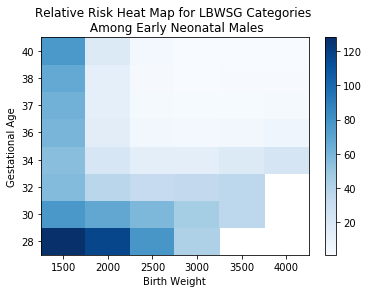

In [21]:
df = data.loc[data.sex_id==1].loc[data.age_group_id==2].loc[data.bw_start >= 1500]
df = pd.DataFrame.pivot_table(df, 
                    index='ga_start', 
                    columns='bw_start', 
                    values='value')

plt.pcolor(df, cmap=plt.cm.Blues)
plt.colorbar()
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.xlabel('Birth Weight')
plt.ylabel('Gestational Age')
plt.title('Relative Risk Heat Map for LBWSG Categories \n Among Early Neonatal Males')
plt.show()

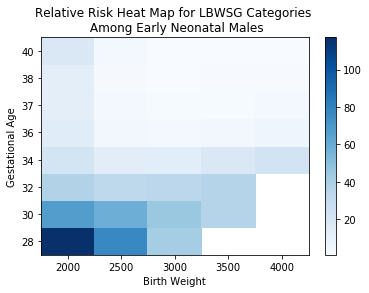

In [20]:
df = data.loc[data.sex_id==1].loc[data.age_group_id==2].loc[data.bw_start >= 2000]
df = pd.DataFrame.pivot_table(df, 
                    index='ga_start', 
                    columns='bw_start', 
                    values='value')

plt.pcolor(df, cmap=plt.cm.Blues)
plt.colorbar()
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.xlabel('Birth Weight')
plt.ylabel('Gestational Age')
plt.title('Relative Risk Heat Map for LBWSG Categories \n Among Early Neonatal Males')
plt.show()

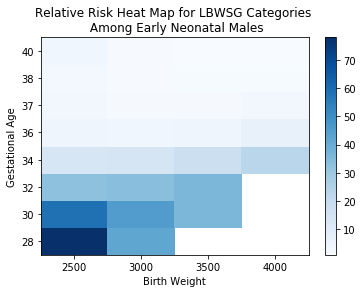

In [23]:
df = data.loc[data.sex_id==1].loc[data.age_group_id==2].loc[data.bw_start >= 2500]
df = pd.DataFrame.pivot_table(df, 
                    index='ga_start', 
                    columns='bw_start', 
                    values='value')

plt.pcolor(df, cmap=plt.cm.Blues)
plt.colorbar()
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.xlabel('Birth Weight')
plt.ylabel('Gestational Age')
plt.title('Relative Risk Heat Map for LBWSG Categories \n Among Early Neonatal Males')
plt.show()

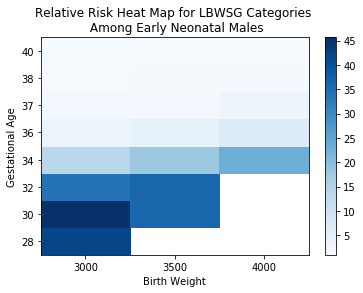

In [24]:
df = data.loc[data.sex_id==1].loc[data.age_group_id==2].loc[data.bw_start >= 3000]
df = pd.DataFrame.pivot_table(df, 
                    index='ga_start', 
                    columns='bw_start', 
                    values='value')

plt.pcolor(df, cmap=plt.cm.Blues)
plt.colorbar()
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.xlabel('Birth Weight')
plt.ylabel('Gestational Age')
plt.title('Relative Risk Heat Map for LBWSG Categories \n Among Early Neonatal Males')
plt.show()